<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/02-Machine-Learning/notebooks/13-Clustering-Grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterizando nodos de un grafo

In [1]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='darkgrid')

## 1. El conjunto de datos 

Este dataset del módulo networkx es contiene información de los miembros de un club de karate universitario. El grafo representa la presencia o ausencia de lazos entre los miembros del club. Los pesos de las aristas indican la fuerza del lazo entre miembros (el número de situaciones dentro y fuera del club en las cuales las interacciones occurren).

Estos datos primero se usaron para explicar la ruptura de este grupo como consecuencia de las disuputas entre miembros. 

[Link](http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/UciData.htm#zachary) del dataset.

In [2]:
kn = nx.karate_club_graph()

num_nodes = kn.number_of_nodes()
print(f"Number of nodes: {str(num_nodes)}")
num_edges = kn.number_of_edges()
print(f"Number of edges: {str(num_edges)}")

Number of nodes: 34
Number of edges: 78


Graficamos el grafo:

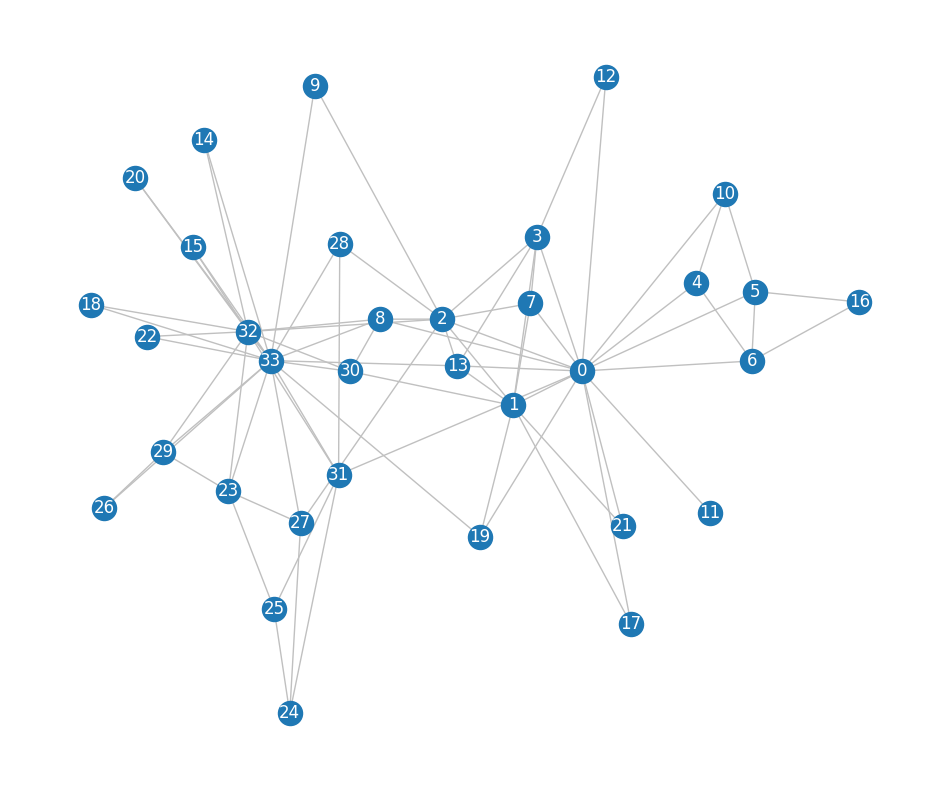

In [3]:
plt.figure(figsize=(12,10))
nx.draw_networkx(kn, edge_color='silver', with_labels=True, font_color='white')
plt.axis('off')
plt.show()

Calculamos la centralidad de los nodos en un diccionario:

In [4]:
deg_centrality_dict = nx.degree_centrality(kn).copy()

Ordenamos el diccionario por los valores de centralidad

In [5]:
deg_centrality_dict_sorted = dict(sorted(deg_centrality_dict.items(), 
                                         key=lambda x:x[1],reverse=True))
print(deg_centrality_dict_sorted)

{33: 0.5151515151515151, 0: 0.48484848484848486, 32: 0.36363636363636365, 2: 0.30303030303030304, 1: 0.2727272727272727, 3: 0.18181818181818182, 31: 0.18181818181818182, 8: 0.15151515151515152, 13: 0.15151515151515152, 23: 0.15151515151515152, 5: 0.12121212121212122, 6: 0.12121212121212122, 7: 0.12121212121212122, 27: 0.12121212121212122, 29: 0.12121212121212122, 30: 0.12121212121212122, 4: 0.09090909090909091, 10: 0.09090909090909091, 19: 0.09090909090909091, 24: 0.09090909090909091, 25: 0.09090909090909091, 28: 0.09090909090909091, 9: 0.06060606060606061, 12: 0.06060606060606061, 14: 0.06060606060606061, 15: 0.06060606060606061, 16: 0.06060606060606061, 17: 0.06060606060606061, 18: 0.06060606060606061, 20: 0.06060606060606061, 21: 0.06060606060606061, 22: 0.06060606060606061, 26: 0.06060606060606061, 11: 0.030303030303030304}


Dibujamos los 5 nodos con centralidad más alta

Los 5 nodos con centralidad más alta: [33, 0, 32, 2, 1]


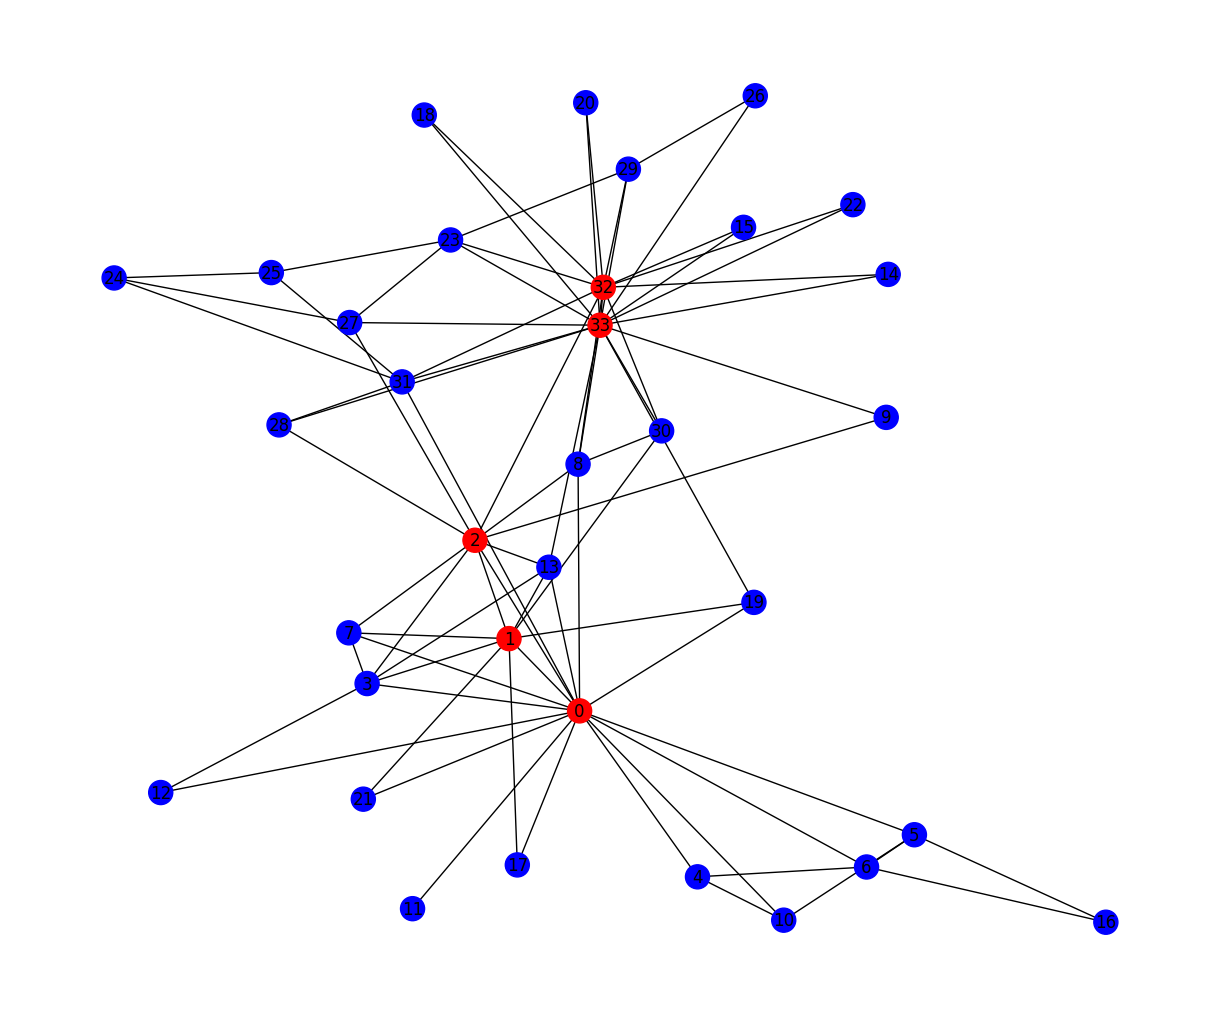

In [6]:
top_num = 5
top_nodes = list(deg_centrality_dict_sorted.keys())[:top_num]
print(f"Los {top_num} nodos con centralidad más alta: {top_nodes}")

colores = ['red' if x in top_nodes else 'blue' for x in kn.nodes() ]

fig = plt.figure(figsize=(12,10))
nx.draw_spring(kn,node_color=colores,with_labels=True)
fig.show()

## 2. Extrayendo features

The adjacency matrix of a finite graph is a square matrix used to represent the graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph. 

The Laplacian matrix is another matrix representing the graph. It is defined as

$$L = D - A,$$

where $D$ is the matrix containing the degree of each node in the diagonal and $A$, the adjancecy matrix. 

In [7]:
A = nx.adjacency_matrix(kn)
print("ADJACENCY MATRIX:")
print(A.todense())
print('-'*50)
print("DEGREE OF EACH NODE:")
print(kn.degree)
L = nx.laplacian_matrix(kn).astype(float)
print('-'*50)
print("LAPLACIAN MATRIX:")
print(L.todense())


ADJACENCY MATRIX:
[[0 4 5 ... 2 0 0]
 [4 0 6 ... 0 0 0]
 [5 6 0 ... 0 2 0]
 ...
 [2 0 0 ... 0 4 4]
 [0 0 2 ... 4 0 5]
 [0 0 0 ... 4 5 0]]
--------------------------------------------------
DEGREE OF EACH NODE:
[(0, 16), (1, 9), (2, 10), (3, 6), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (9, 2), (10, 3), (11, 1), (12, 2), (13, 5), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 3), (20, 2), (21, 2), (22, 2), (23, 5), (24, 3), (25, 3), (26, 2), (27, 4), (28, 3), (29, 4), (30, 4), (31, 6), (32, 12), (33, 17)]
--------------------------------------------------
LAPLACIAN MATRIX:
[[42. -4. -5. ... -2.  0.  0.]
 [-4. 29. -6. ...  0.  0.  0.]
 [-5. -6. 33. ...  0. -2.  0.]
 ...
 [-2.  0.  0. ... 21. -4. -4.]
 [ 0.  0. -2. ... -4. 38. -5.]
 [ 0.  0.  0. ... -4. -5. 48.]]


Obtenemos los $k$ primeros eigenvalores y eigenvectores.

In [8]:
import scipy as sp

eigenvalues, eigenvectors = sp.sparse.linalg.eigsh(L, k = 3, which='SM')
print(eigenvalues.shape,eigenvectors.shape)

(3,) (34, 3)


Obtenemos una representación espectral de cada nodo con 3 componentes

In [9]:
X = eigenvectors*eigenvalues
print(X)
X.shape

[[-1.58693427e-15  1.46390633e-01 -1.47390748e-01]
 [-1.58693427e-15  6.88600641e-02 -3.14055847e-01]
 [-1.58693427e-15  1.62449217e-02 -1.93108969e-01]
 [-1.58693427e-15  8.83811189e-02 -3.96587161e-01]
 [-1.58693427e-15  3.17359330e-01  3.92548201e-01]
 [-1.58693427e-15  3.54724772e-01  6.03791917e-01]
 [-1.58693427e-15  3.53099824e-01  6.00396278e-01]
 [-1.58693427e-15  7.60478054e-02 -3.31256647e-01]
 [-1.58693427e-15 -6.29228542e-02 -5.21811972e-02]
 [-1.58693427e-15 -1.53440063e-01 -8.60397112e-02]
 [-1.58693427e-15  3.38921171e-01  4.80626526e-01]
 [-1.58693427e-15  2.42249251e-01 -7.30041775e-01]
 [-1.58693427e-15  1.46302769e-01 -8.32763447e-01]
 [-1.58693427e-15  4.14678969e-02 -2.44428546e-01]
 [-1.58693427e-15 -2.03667274e-01  1.72493293e-01]
 [-1.58693427e-15 -1.84241618e-01  1.28202291e-01]
 [-1.58693427e-15  4.41205305e-01  1.00190917e+00]
 [-1.58693427e-15  1.99483031e-01 -1.00521166e+00]
 [-1.58693427e-15 -2.51052190e-01  4.02552669e-01]
 [-1.58693427e-15  7.42989039e-

(34, 3)

## 3. Clustering

In [10]:
def get_cmap(n, name='plasma'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

print([get_cmap(k) for k in range(3)])

[<matplotlib.colors.ListedColormap object at 0x7f4a50ee3250>, <matplotlib.colors.ListedColormap object at 0x7f4a50ee3220>, <matplotlib.colors.ListedColormap object at 0x7f4a50ee3c10>]


<ipython-input-10-1b69f5474798>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


Una función para obtener una lista de $n$ colores muy diferentes

In [11]:
import random
import numpy as np

def get_k_colors(k=3):
    return [(np.cos(np.pi*j/(k*2)),random.uniform(0, 1),j/k) for j in range(k)]

In [12]:
get_k_colors(4)

[(1.0, 0.8387962119585551, 0.0),
 (0.9238795325112867, 0.9202720817208158, 0.25),
 (0.7071067811865476, 0.22095828255580152, 0.5),
 (0.38268343236508984, 0.4643905688357848, 0.75)]

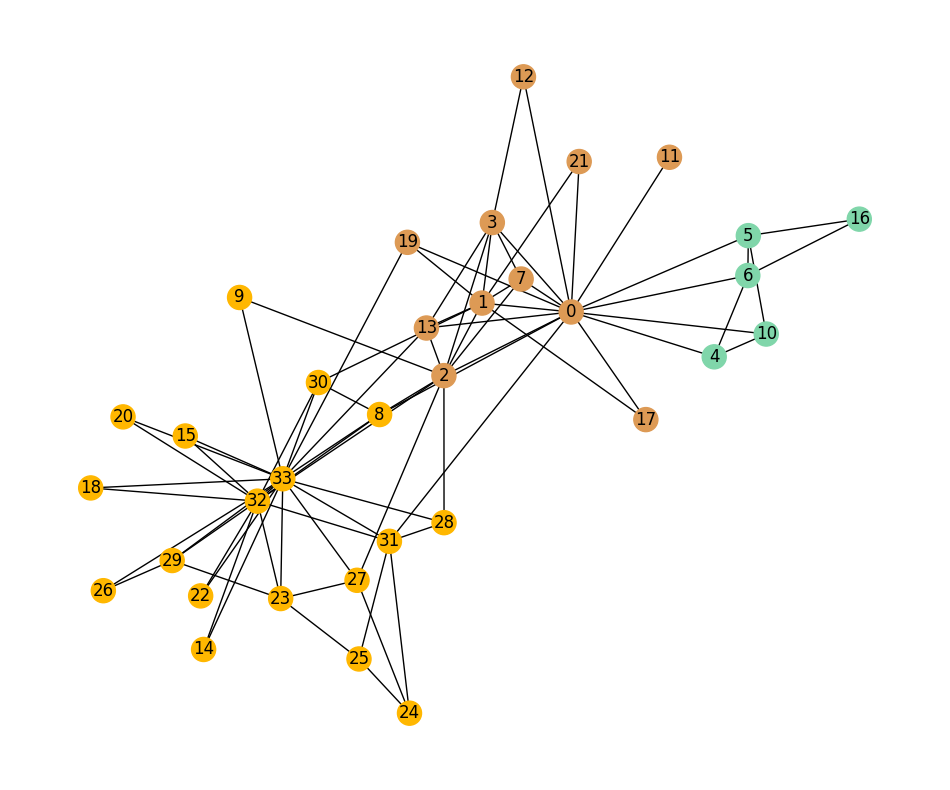

In [13]:
from sklearn.cluster import KMeans

k = 3
clusters_colors = get_k_colors(k)

model = KMeans(init='k-means++', n_clusters=k, n_init=10)
model.fit_predict(X)
clusters = model.labels_

fig = plt.subplots(1, figsize=(12,10))
node_colors = [clusters_colors[clusters[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')

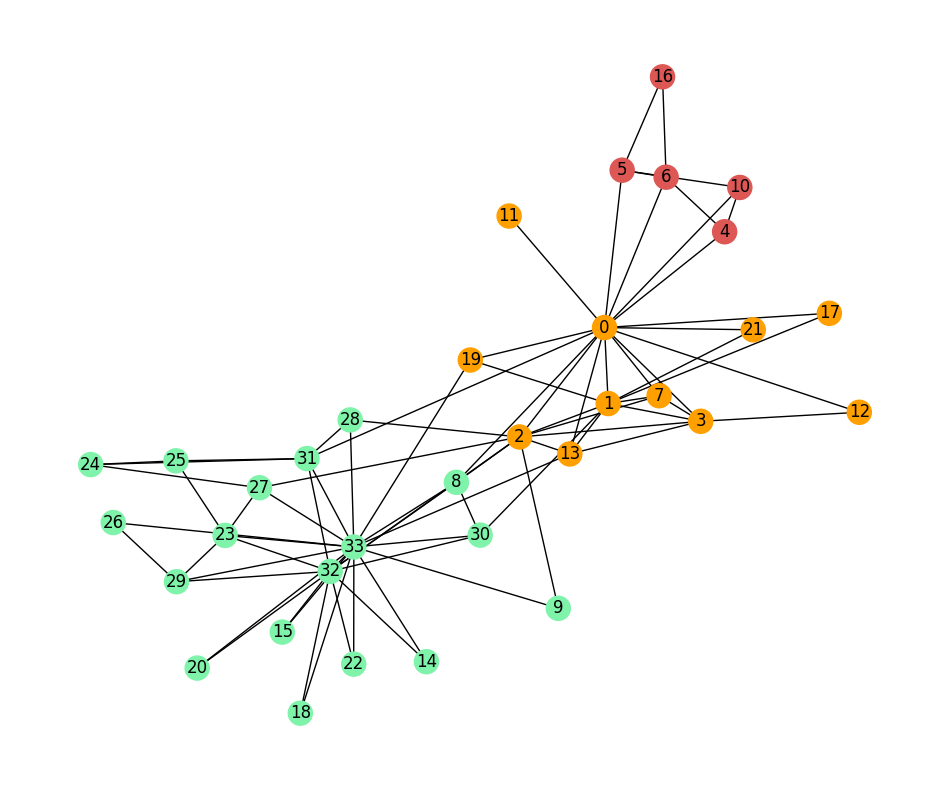

In [14]:
from sklearn.cluster import AgglomerativeClustering

k = 3
clusters_colors = get_k_colors(k)

model = AgglomerativeClustering(n_clusters=k) #, affinity='precomputed', linkage='complete')
model.fit(X)
clusters = model.labels_

fig = plt.subplots(1, figsize=(12,10))
node_colors = [clusters_colors[clusters[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')

5 clusters encontrados


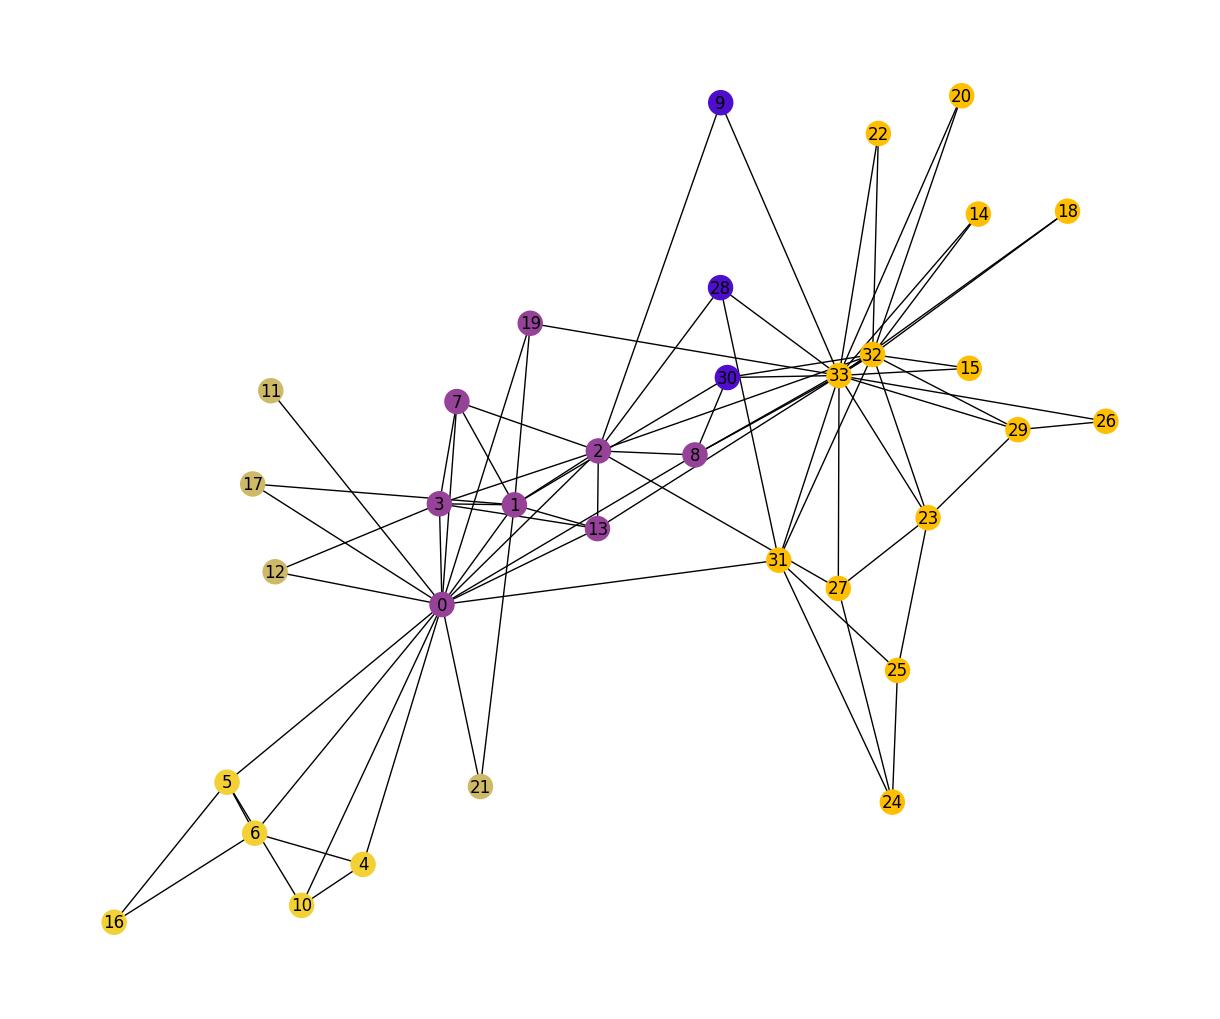

In [15]:
from sklearn.cluster import SpectralClustering

k = 5
clusters_colors = get_k_colors(k)

model = SpectralClustering(n_clusters=k)
model.fit(X)
clusters = model.labels_

print(f"{len(np.unique(clusters))} clusters encontrados")

plt.figure(figsize=(12,10))
node_colors = [clusters_colors[clusters[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')

La matriz de adyacencia no contiene la información necesaria para distinguir clusters.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


3 clusters encontrados


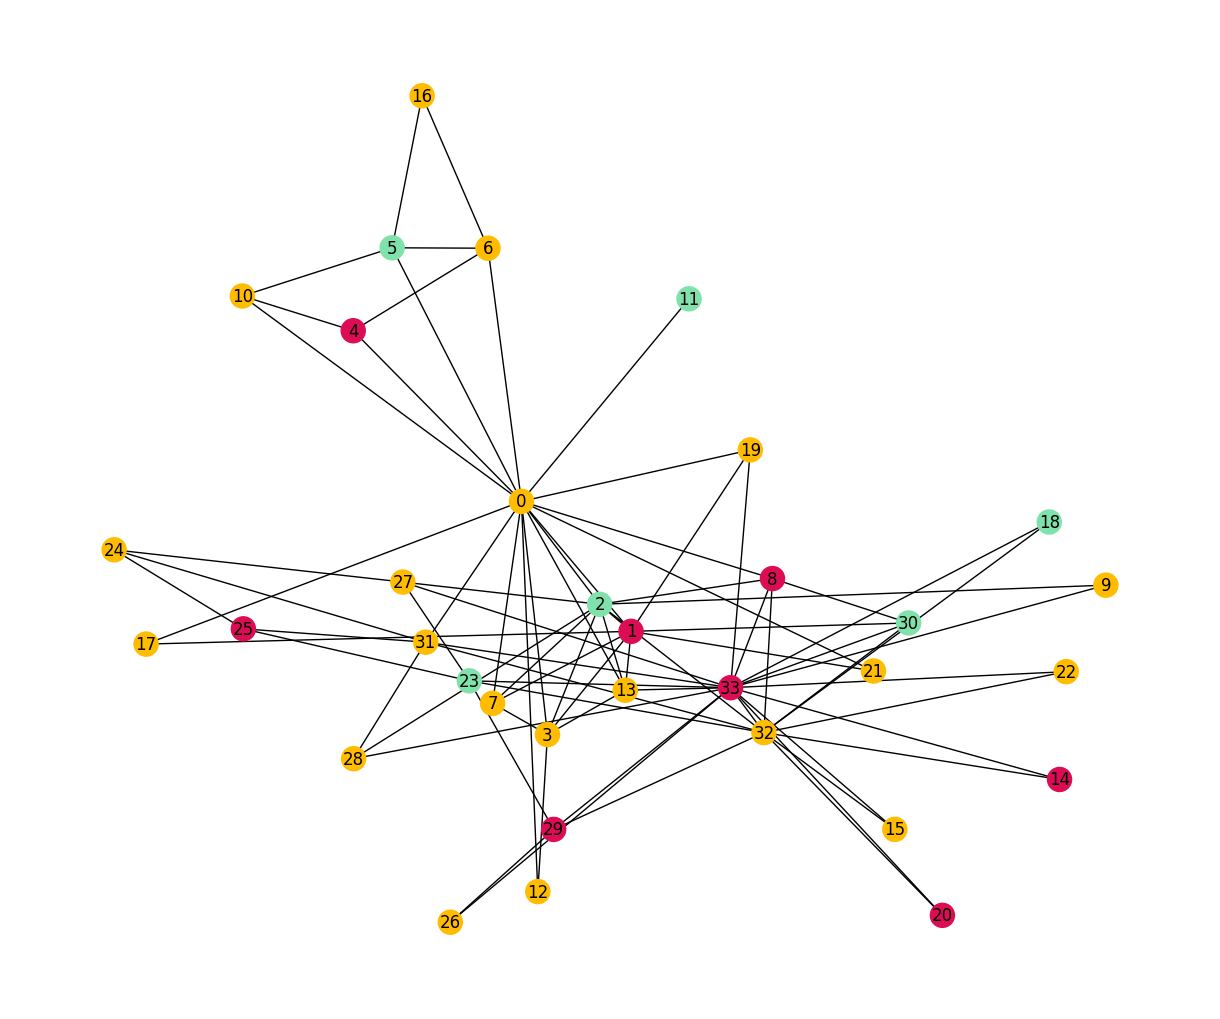

In [16]:
from sklearn.cluster import AgglomerativeClustering

k = 3
clusters_colors = get_k_colors(k)

model = AgglomerativeClustering(n_clusters=k, affinity='precomputed', linkage='complete')
model.fit(A.toarray())
clusters = model.labels_

print(f"{len(np.unique(clusters))} clusters encontrados")

plt.figure(figsize=(12,10))
node_colors = [clusters_colors[clusters[v]] for v in kn.nodes()]
nx.draw(kn, node_color=node_colors, with_labels='True')